<a href="https://colab.research.google.com/github/VKSi/2021_01_NeuralNetworks/blob/main/HW_3_TF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Введение в искусственные нейронные сети
# Урок 3. TensorFlow

## Практическое задание

  1. Постройте нейронную сеть(берем простую линейную сеть, которую разбирали на уроке: меняем число слоев, число нейронов , типы активации, тип оптимизатора)  на датасет from sklearn.datasets import load_boston. 
  2. Измените функцию потерь и метрику для этой задачи. Постройте 10-15 вариантов и сведите результаты их работы в таблицу  Опишите, какого результата вы добились от нейросети? Что помогло вам улучшить ее точность?

  3. Поработайте с документацией TensorFlow 2. Найти 2-3 полезные команды TensorFlow, не разобранные на уроке (полезные для Вас).

  1-2. (*)  Попробуйте обучить нейронную сеть на TensorFlow 2 на датасете imdb_reviews .Опишите, какого результата вы добились от нейросети? Что помогло вам улучшить ее точность?
    
    
</ol>



## Набор данных для последнего ДЗ

- COVID 19 диагностика https://www.kaggle.com/andrewmvd/covid19-ct-scans

- Распознавание изображений цифр в представлении языка жестов https://www.kaggle.com/ardamavi/sign-language-digits-dataset

# Решения

При подготовке работы частично использовался тьюториал: https://machinelearningmastery.com/regression-tutorial-keras-deep-learning-library-python/

## Подготовка данных

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
PATH = 'gdrive/My Drive/AI/GB/NeuralNetwork/Lesson3/'

In [ ]:
import tensorflow as tf
print(tf.__version__)
msg = tf.constant('TensorFlow 2.0 Hello World')
tf.print(msg)

2.4.0
TensorFlow 2.0 Hello World


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.utils import plot_model, to_categorical

### Знакомимся с датасетом

In [ ]:
 from sklearn.datasets import load_boston

In [ ]:
X, y = load_boston(return_X_y=True)

In [ ]:
X.shape

(506, 13)

In [ ]:
y.shape

(506,)

In [ ]:
X[:3][:]

array([[6.3200e-03, 1.8000e+01, 2.3100e+00, 0.0000e+00, 5.3800e-01,
        6.5750e+00, 6.5200e+01, 4.0900e+00, 1.0000e+00, 2.9600e+02,
        1.5300e+01, 3.9690e+02, 4.9800e+00],
       [2.7310e-02, 0.0000e+00, 7.0700e+00, 0.0000e+00, 4.6900e-01,
        6.4210e+00, 7.8900e+01, 4.9671e+00, 2.0000e+00, 2.4200e+02,
        1.7800e+01, 3.9690e+02, 9.1400e+00],
       [2.7290e-02, 0.0000e+00, 7.0700e+00, 0.0000e+00, 4.6900e-01,
        7.1850e+00, 6.1100e+01, 4.9671e+00, 2.0000e+00, 2.4200e+02,
        1.7800e+01, 3.9283e+02, 4.0300e+00]])

In [ ]:
X[0].shape

(13,)

In [ ]:
y[:3]

array([24. , 21.6, 34.7])

In [ ]:
np.min(X, axis=0) >= 0

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [ ]:
def baseline_model():
  inputs = Input(shape=(13))
  x = Dense(128, activation='relu')(inputs)
  outputs = Dense(1)(x)
  model = Model(inputs,outputs)
  model.compile(loss='mean_squared_error', optimizer='adam', metrics='MSE')
  return model

In [ ]:
baseline_model().summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 13)]              0         
_________________________________________________________________
dense (Dense)                (None, 128)               1792      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 1,921
Trainable params: 1,921
Non-trainable params: 0
_________________________________________________________________


Так как параметры датасета измеряют разные величины, есть смысл при обучении и оценке использовать нормализацию

Оценим базовую модель. К предложенной в тюториал модели кросс-валидации добавим еще усреднение по нескольким запускам. Это даст возможность получать более устойчивый результат с учетом различия в начальной активации весов. Поместим это все в процедуру и сделаем ее параметрической.

In [ ]:
def print_simple_result(model_, X, y, metrics, number_of_folds=5, number_of_starts=1, number_of_epochs=10):
  results = list()
  for i in range(number_of_starts):
    kfold = KFold(n_splits=number_of_folds)

    estimators = []
    estimators.append(('standardize', StandardScaler()))
    estimators.append(('mlp', KerasRegressor(build_fn=model_, epochs=number_of_epochs, batch_size=5, verbose=0)))
    pipeline = Pipeline(estimators)

    results += list(cross_val_score(pipeline, X, y, cv=kfold))

  print(f"{metrics}: среднее значение = {np.mean(results):.2f}, стандартное отклонение =  {np.std(results):.2f}")
  return results

In [ ]:
r = print_simple_result(baseline_model, X, y, metrics = 'MSE', number_of_starts=5, number_of_epochs=50)

MSE: среднее значение = -23.27, стандартное отклонение =  13.29


Перепишем функцию создания модели так, чтобы в нее можно было передавать соответствующие заданию параметры: 

In [ ]:
def parametric_model(neurons_number=128,
                     activation_func='relu',
                     optimizer_type='adam',
                     layers_number = 1,
                     loss_function='mean_squared_error',
                     metrics='MSE'):
  def b_func():
    inputs = Input(shape=(13))
    x = Flatten()(inputs)
    for i in range(layers_number):
      x = Dense(neurons_number, activation=activation_func, name='dense_'+str(i))(x)
    outputs = Dense(1)(x)
    model = Model(inputs,outputs)
    model.compile(loss=loss_function, optimizer=optimizer_type, metrics=metrics)
    return model

  return b_func, b_func()

Проверяем, что при параметрах по-умолчанию результат сохранился

In [ ]:
pm_func, pm = parametric_model(neurons_number = 128,
                                activation_func = 'relu',
                                optimizer_type = 'adam',
                                layers_number = 1,
                                loss_function = 'mean_squared_error',
                                metrics = 'MSE')

In [ ]:
pm.summary()

Model: "model_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        [(None, 13)]              0         
_________________________________________________________________
flatten (Flatten)            (None, 13)                0         
_________________________________________________________________
dense_0 (Dense)              (None, 128)               1792      
_________________________________________________________________
dense_52 (Dense)             (None, 1)                 129       
Total params: 1,921
Trainable params: 1,921
Non-trainable params: 0
_________________________________________________________________


In [ ]:
r = print_simple_result(pm_func, X, y, metrics='MSE',
                        number_of_folds=5,
                        number_of_starts=5,
                        number_of_epochs=50)

MSE: среднее значение = -24.00, стандартное отклонение =  13.34


Проверим работу на небазовых параметрах:

In [ ]:
pm_func, pm = parametric_model(neurons_number = 256,
                                activation_func = 'exponential',
                                optimizer_type = 'rmsprop',
                                layers_number = 2,
                                loss_function = 'mean_absolute_error',
                                metrics = 'mean_absolute_error')

In [ ]:
pm.summary()

Model: "model_52"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_53 (InputLayer)        [(None, 13)]              0         
_________________________________________________________________
flatten_26 (Flatten)         (None, 13)                0         
_________________________________________________________________
dense_0 (Dense)              (None, 256)               3584      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_78 (Dense)             (None, 1)                 257       
Total params: 69,633
Trainable params: 69,633
Non-trainable params: 0
_________________________________________________________________


In [ ]:
r = print_simple_result(pm_func, X, y, metrics='mean_absolute_error',
                        number_of_folds=5,
                        number_of_starts=5,
                        number_of_epochs=50)

mean_absolute_error: среднее значение = -273.04, стандартное отклонение =  1099.52


Осталось запустить процедуру для разных параметров и пойти пару часиков вздремнуть:

In [ ]:
neurons_number_grid = [128, 256, 512]
activation_func_grid = ['relu', 'sigmoid', 'tanh', 'exponential']
optimizer_type_grid = ['adam', 'sgd', 'rmsprop']
layers_number_grid = list(range(1, 5))
loss_function_grid = ['mean_squared_error', 'mean_absolute_percentage_error'] # Так как разброс таргета (цены продажи) может быть большим, есть смысл посмотреть на процентные отклонения
# Для метрики используем те же функции что и для потерь

In [ ]:
# df = pd.DataFrame()

In [ ]:
data = pd.read_csv(PATH + f'results_{144}.csv')  # Запускать пришлось в несколько заходов

In [ ]:
df = data.copy()
experiment_number = 0
for loss_function in loss_function_grid:
  for optimizer_type in optimizer_type_grid:
    for activation_func in activation_func_grid:
      for layers_number in layers_number_grid:
        for neurons_number in neurons_number_grid:
          experiment_number += 1
          if experiment_number <= data.index.max():
            continue
          df.loc[experiment_number, 'loss_function'] = loss_function
          df.loc[experiment_number, 'optimizer_type'] = optimizer_type
          df.loc[experiment_number, 'activation_func'] = activation_func
          df.loc[experiment_number, 'layers_number'] = layers_number
          df.loc[experiment_number, 'neurons_number'] = neurons_number
          print('*'*50)
          print('experiment_number: ', experiment_number)
          print('loss_function: ', loss_function)
          print('optimizer_type: ', optimizer_type)
          print('activation_func: ', activation_func)
          print('layers_number: ', layers_number)
          print('neurons_number: ', neurons_number)
          pm_func, pm = parametric_model(neurons_number = neurons_number,
                                activation_func = activation_func,
                                optimizer_type = optimizer_type,
                                layers_number = layers_number,
                                loss_function = loss_function,
                                metrics = loss_function)
          r = print_simple_result(pm_func, X, y, metrics=loss_function,
                        number_of_folds=5,
                        number_of_starts=5,
                        number_of_epochs=50)
          df.loc[experiment_number, 'result'] = np.mean(r)
          df.loc[experiment_number, 'std'] = np.std(r)
          print('result:', df.loc[experiment_number, 'result'])
          print('std: ', df.loc[experiment_number, 'std'])
      df.to_csv(PATH + f'results_{experiment_number}.csv')

**************************************************
experiment_number:  145
loss_function:  mean_absolute_percentage_error
optimizer_type:  adam
activation_func:  relu
layers_number:  1
neurons_number:  128
mean_absolute_percentage_error: среднее значение = -16.48, стандартное отклонение =  6.66
result: -16.480697898864747
std:  6.65693316169931
**************************************************
experiment_number:  146
loss_function:  mean_absolute_percentage_error
optimizer_type:  adam
activation_func:  relu
layers_number:  1
neurons_number:  256
mean_absolute_percentage_error: среднее значение = -16.61, стандартное отклонение =  7.04
result: -16.607696685791016
std:  7.035343663192917
**************************************************
experiment_number:  147
loss_function:  mean_absolute_percentage_error
optimizer_type:  adam
activation_func:  relu
layers_number:  1
neurons_number:  512
mean_absolute_percentage_error: среднее значение = -16.43, стандартное отклонение =  6.85
result: -

In [ ]:
df

,Unnamed: 0,Unnamed: 0.1,loss_function,optimizer_type,activation_func,layers_number,neurons_number,result,std
0,0.0,0.0,mean_squared_error,adam,relu,1.0,128.0,-23.760973,13.643399
1,1.0,1.0,mean_squared_error,adam,relu,1.0,256.0,-23.277733,12.455523
2,2.0,2.0,mean_squared_error,adam,relu,1.0,512.0,-23.762585,12.942701
3,3.0,3.0,mean_squared_error,adam,relu,2.0,128.0,-32.056978,27.134633
4,4.0,4.0,mean_squared_error,adam,relu,2.0,256.0,-28.692733,18.454465
...,...,...,...,...,...,...,...,...,...
284,NaN,NaN,mean_absolute_percentage_error,rmsprop,exponential,3.0,256.0,NaN,NaN
285,NaN,NaN,mean_absolute_percentage_error,rmsprop,exponential,3.0,512.0,NaN,NaN
286,NaN,NaN,mean_absolute_percentage_error,rmsprop,exponential,4.0,128.0,NaN,NaN
287,NaN,NaN,mean_absolute_percentage_error,rmsprop,exponential,4.0,256.0,NaN,NaN


## Визуализация результата

In [ ]:
data = pd.read_csv(PATH + f'results_{288}.csv')

In [ ]:
data.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,loss_function,optimizer_type,activation_func,layers_number,neurons_number,result,std
0,0,0.0,0.0,mean_squared_error,adam,relu,1.0,128.0,-23.760973,13.643399
1,1,1.0,1.0,mean_squared_error,adam,relu,1.0,256.0,-23.277733,12.455523
2,2,2.0,2.0,mean_squared_error,adam,relu,1.0,512.0,-23.762585,12.942701
3,3,3.0,3.0,mean_squared_error,adam,relu,2.0,128.0,-32.056978,27.134633
4,4,4.0,4.0,mean_squared_error,adam,relu,2.0,256.0,-28.692733,18.454465


Уппссс, забыл при сохранении изменить параметр index=, придется почистить

In [ ]:
data=data.iloc[:, 3:]

In [ ]:
data.head()

,loss_function,optimizer_type,activation_func,layers_number,neurons_number,result,std
0,mean_squared_error,adam,relu,1.0,128.0,-23.760973,13.643399
1,mean_squared_error,adam,relu,1.0,256.0,-23.277733,12.455523
2,mean_squared_error,adam,relu,1.0,512.0,-23.762585,12.942701
3,mean_squared_error,adam,relu,2.0,128.0,-32.056978,27.134633
4,mean_squared_error,adam,relu,2.0,256.0,-28.692733,18.454465


#### Идея с визаулизацией не прокатила. Слишком много пропущенных и выбросов. МОжно было бы подумать еще как это делать нагляднее, но уже исчерпал лимиты времени на задание

Функция потерь mean_squared_error


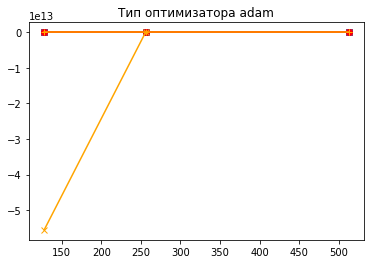

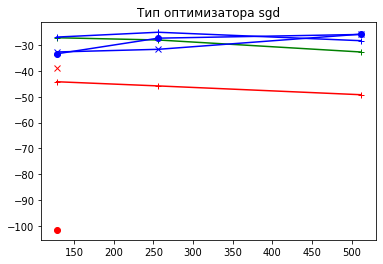

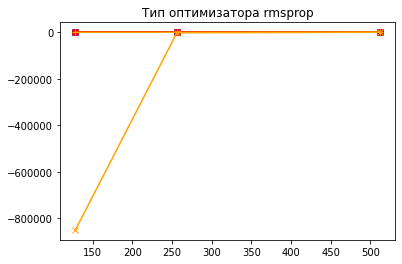

Функция потерь mean_absolute_percentage_error


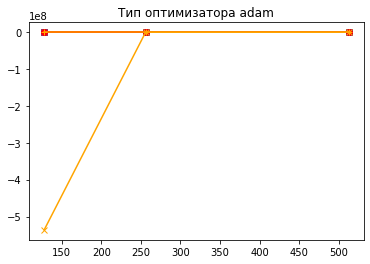

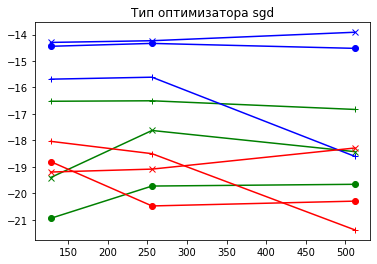

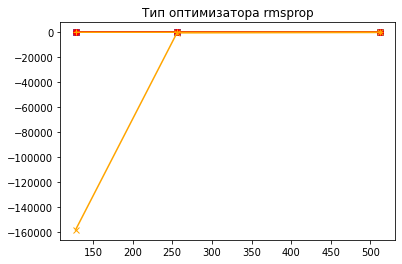

In [ ]:
colors = ['green', 'blue', 'red', 'orange']
markers = ['+', 'x', 'o', '-']
for loss_function in loss_function_grid:
  print(f'Функция потерь {loss_function}')
  for optimizer_type in optimizer_type_grid:
    plt.title(f'Тип оптимизатора {optimizer_type}')
    for i, activation_func in enumerate(activation_func_grid):
      c = colors[i]
      for j, layers_number in enumerate(layers_number_grid):
        m = markers[j]
        dt = data.loc[(data.loss_function == loss_function) & (data.optimizer_type == optimizer_type) & (data.activation_func == activation_func) & (data.layers_number == layers_number), ['neurons_number', 'result']]
        try:
          plt.plot(dt.neurons_number, dt.result, color=c, marker=m, label=f'{loss_function}, {activation_func}')
        except:
          pass
    plt.show()

### Посмотрим на лучшие результаты по каждому варианту метрики:

In [ ]:
data_abs = data.head(145)
data_per = data.tail(144)

In [ ]:
data_abs.head(1)

,loss_function,optimizer_type,activation_func,layers_number,neurons_number,result,std
0,mean_squared_error,adam,relu,1.0,128.0,-23.760973,13.643399


In [ ]:
data_abs[data_abs.result == max(data_abs[~data_abs.result.isna()].result)]

,loss_function,optimizer_type,activation_func,layers_number,neurons_number,result,std
135,mean_squared_error,rmsprop,exponential,1.0,512.0,-22.244308,15.718428


In [ ]:
data_per.head(1)

,loss_function,optimizer_type,activation_func,layers_number,neurons_number,result,std
145,mean_absolute_percentage_error,adam,relu,1.0,128.0,-16.480698,6.656933


In [ ]:
data_per[data_per.result == max(data_per[~data_per.result.isna()].result)]

,loss_function,optimizer_type,activation_func,layers_number,neurons_number,result,std
210,mean_absolute_percentage_error,sgd,sigmoid,2.0,512.0,-13.911233,5.115122


**ВИДНО**, что "лучшие" результаты оптимизации лежат в пределах одного стандартного отклонения от базовой простейшей модели.  
Никакого намека на статистическую значимость улучшения  

Полезным для себя я нашел KerasRegressor. Эта надстройка позволяет рассматривать нейронную сеть в терминах scikit_learn, что очень удобно для анализа и организации pipelines 